<a href="https://colab.research.google.com/github/daniellegruber/RL-Brain-Trajectories/blob/main/RL_Data_Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Setup

In [ ]:
# @title Install dependencies
!pip install stable-baselines3 > /dev/null
!pip install box2d-py > /dev/null
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
# Imports
import io
import os
import glob
import base64
import pdb
import sys
import math
import random
import gc

import numpy as np
from numpy import diag, matmul, reshape
from numpy.matlib import repmat

from scipy.sparse.linalg import svds
from scipy.linalg import schur, eig

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

import stable_baselines3

import gym
from gym import spaces
from gym import wrappers

import torch
from torch.linalg import svdvals
from torch import unsqueeze, tensor
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
import torchvision.transforms as T
import torch.nn.functional as F
import torch.distributions as distributions

from tqdm.auto import tqdm

from collections import namedtuple
from itertools import count

from typing import List, Union

from google.colab import drive

from collections import deque

from datetime import datetime

!pip install cdlib
from cdlib import algorithms
import networkx as nx
import community.community_louvain as community_louvain

from collections import defaultdict

In [ ]:
#@title Set random seed

#@markdown Executing `set_seed(seed=seed)` you are setting the see
# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
#@title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
# Set global variables
SEED = 1
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 1 has been set.


# Set up custom Gym environment
Some reminders about terminology and requirements:
* In `__init__`, you need to create two variables with fixed names and types.
* You need a self.action_space, and a self.observation_space.
* The reset function returns a value that is within self.observation_space. 
  * This is the function that will re-start the environment, for example, at the beginning of a game. 
* The step function has one input parameter, needs an action value, usually called action, that is within self.action_space.
* Similarly to state in the previous point, action can be an integer or a numpy.array.
  * This is the response function, the agent provides the action they want to take, and the environment returns the state it brought them to. 
* The return value is a 4-tuple, in the following order (the naming does not matter, but the variable type does):
  * state, same type of variable as the return of the reset function, of self.observation_space;
  * reward, a number that informs the agent about the immediate consequences of its action;
  * done, a boolean, value that is TRUE if the environment reached an endpoint, and should be reset, or FALSE otherwise;
  * info, a dictionary that can be used in bug fixing, and as far as I know, the baselines algorithms don’t use it.
* You need to provide these variables, but they don’t all have to have “proper“ values. For example, the info can be just an empty dictionary.
* You can have as many helping functions within your class as you want, and it doesn’t matter what you call them, as long as they don’t use any of the reserved names.


In [ ]:
class BaseEnv(gym.Env):
  def __init__(self, A: np.ndarray, B: np.ndarray, init_state: np.ndarray,
               target_state: np.ndarray, rho: float, state_update_scaler: float,
               action_lim: np.ndarray, state_lim: np.ndarray):

    if torch.is_tensor(A):
      A = A.numpy()
    if torch.is_tensor(B):
      B = B.numpy()
    if torch.is_tensor(init_state):
      init_state = init_state.numpy()
    if torch.is_tensor(target_state):
      target_state = target_state.numpy()

    self.A = A
    self.B = B
    # Initial and target states
    self.init_state = init_state
    self.target_state = target_state

    # Scaling parameter for cost of control signal
    self.rho = rho
    self.state_update_scaler = state_update_scaler

    # Lower and upper bounds on actions and states, each formatted as a numpy array of shape (2,)
    self.action_lim = action_lim
    self.state_lim = state_lim

    # Initialize current state as inital state
    self.current_state = init_state

    # Number of control regions and number of all regions
    self.num_ROI = A.shape[0]
    self.num_ctrl_ROI = B.shape[1]

    # set continuous action space with dimension = # agents
    # set continuous observation space with dimension = # ROI

    self.action_space = gym.spaces.Box(
        low=action_lim[0], high=action_lim[1], shape = (self.num_ctrl_ROI,), dtype=np.float32)
    self.observation_space = gym.spaces.Box(
        low=state_lim[0], high=state_lim[1], shape = (self.num_ROI,), dtype=np.float32)

  def _compute_reward(self, *reward_args): 
    raise NotImplementedError

  def _compute_penalty(self, *penalty_args):
    raise NotImplementedError

  def _reward_function(self, reward_args: List, penalty_args: List): 
    return self._compute_reward(*reward_args) - self._compute_penalty(*penalty_args)

  def _transition_state(self, *args): 
    raise NotImplementedError

  def step(self, action):
    self.current_state = self._transition_state(self.current_state, action)
    
    # cost is difference between current state and target state plus a term 
    # penalizing the use of high-magnitude signals/actions
    reward = self._reward_function([self.current_state], [action])

    thresh = 0.01
    if np.linalg.norm(self.current_state - self.target_state) < thresh:
      done = True
    else:
      done = False
    
    info = {}
    return self.current_state, reward, done, info

  def reset(self):
    self.current_state = self.init_state
    return self.current_state

class CustomEnv(BaseEnv):

  def _compute_reward(self, *reward_args): 
    #dist1 = self.target_state
    #dist2 = np.abs(1 - self.target_state)
    #max_dist = np.maximum(dist1, dist2)

    #reward = 1 - np.log(1 + np.sum(np.abs(self.target_state - self.current_state)))/np.log(1 + np.sum(np.abs(max_dist)))
    
    #return reward
    return 0

  def _compute_penalty(self, action): 
    state_cost = np.linalg.norm(self.target_state - self.current_state)
    action_cost = self.rho * np.linalg.norm(action)
    return 10 * (state_cost + action_cost)
    #return 0

  def _transition_state(self, state, action):
    transition_state = self.state_update_scaler * self.A @ state + self.B @ action
    
    # Enforce bounds
    transition_state = np.clip(transition_state, 
      min(self.observation_space.low), max(self.observation_space.high))

    return transition_state

class PosNegRewardEnv(CustomEnv):
  def __init__(self, *args,): 
    super().__init__(*args)
    self.curr_dist = np.linalg.norm(self.init_state - self.target_state)

  def _reward_function(self, reward_args, penalty_args): 
    newly_transitioned_state = reward_args[0] # see BaseEnv.step()
    new_dist = np.linalg.norm(newly_transitioned_state - self.target_state)
    progress = self.curr_dist - new_dist

    #dist1 = self.target_state
    #dist2 = np.abs(1 - self.target_state)
    #max_dist = np.maximum(dist1, dist2)

    #dist = 1 - np.log(1 + np.sum(np.abs(self.target_state - self.current_state)))/np.log(1 + np.sum(np.abs(max_dist)))

    self.curr_dist = new_dist
    return 10  * progress
    #return 10  * progress * dist
    #return 10  * (progress + dist)

# Load data
Load HCP data

### Set up directory

In [ ]:
# Directory
drive.mount('/content/gdrive')
parent_dir = "gdrive/MyDrive/Optimal Brain Trajectories"
if not os.path.exists(parent_dir):
  os.mkdir(parent_dir)
if not os.path.exists(os.path.join(parent_dir,'Data Model')):
  os.mkdir(os.path.join(parent_dir,'Data Model'))

save_dir = os.path.join(parent_dir, 'Data Model')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
datestr = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

pre_load_dir = '' # Leave empty if you want to choose randomly
#pre_load_dir = '2021_08_19-01_55_16_PM' # Or put name of directory you want to load params from
if pre_load_dir:
  pre_load = True
  save_dir = os.path.join(save_dir,pre_load_dir)
else:
  pre_load = False
  save_dir = os.path.join(save_dir, datestr)
  os.mkdir(save_dir)

save_dir_specific = os.path.join(save_dir, datestr)
os.mkdir(save_dir_specific)

### Load RSFC

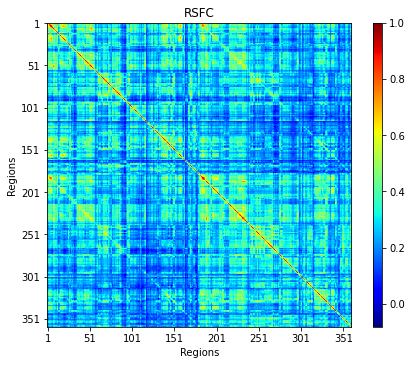

In [ ]:
RSFC = np.load(os.path.join(parent_dir, 'HCP-data', 'RSFC.npy'))
num_ROI = RSFC.shape[0]

#fig = plt.figure(figsize=(8, 8))
#sns.heatmap(RSFC, vmin = np.min(RSFC), vmax = np.max(RSFC))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plt.title('RSFC')
plt.xlabel('Regions')
plt.xticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))
plt.ylabel('Regions')
plt.yticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))

cmap = plt.cm.jet
plt.imshow(RSFC, cmap=cmap, origin='upper')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.3)
plt.colorbar(ax=ax,cax=cax)

### Functions for creating adjacency matrices

In [ ]:
def RSFC_to_binary_adj(RSFC, thresh):
  adj_matrix = np.greater(RSFC, thresh * np.ones((RSFC.shape)))

  fig = plt.figure(figsize=(6, 6))
  plt.imshow(adj_matrix, interpolation='none', origin='upper')
  plt.title('Adjacency Matrix')
  plt.xlabel('Regions')
  plt.xticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))
  plt.ylabel('Regions')
  plt.yticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))

  return adj_matrix

#A = RSFC_to_binary_adj(RSFC, 0.45)

In [ ]:
def RSFC_to_binned_adj(RSFC, num_bins):

  adj_matrix = RSFC
  # Zero out negative coefficients 
  adj_matrix[np.less(adj_matrix,np.zeros(RSFC.shape))] = 0

  # Create bins         
  #bins = np.linspace(0,1,num_bins)
  #for b in range(num_bins-1):
  #  idx = np.greater(adj_matrix, bins[b] * np.ones(RSFC.shape)) & np.less(adj_matrix, bins[b+1] * np.ones(RSFC.shape))
  #  adj_matrix[idx] = b+1

  bins = np.linspace(0,1,num_bins+1)

  # Histogram to visualize how RSFC coefficients fall into bins
  plt.hist(RSFC.flatten('C'), bins)
  plt.title('RSFC Coefficients')
  plt.xlabel('Bins')
  plt.ylabel('Frequency')

  for b in range(num_bins):
    idx = np.greater(adj_matrix, bins[b] * np.ones(RSFC.shape)) & np.less(adj_matrix, bins[b+1] * np.ones(RSFC.shape))
    adj_matrix[idx] = b


  # Plot figure
  fig, ax = plt.subplots(1, 1, figsize=(6, 6))
  plt.title('Adjacency Matrix')
  plt.xlabel('Regions')
  plt.xticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))
  plt.ylabel('Regions')
  plt.yticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))

  cmap = plt.cm.jet
  cmaplist = [cmap(i) for i in range(cmap.N)]

  cmap = mpl.colors.LinearSegmentedColormap.from_list(
      'Custom cmap', cmaplist, cmap.N)

  bounds = np.arange(len(np.unique(adj_matrix))+1)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
  

  plt.imshow(adj_matrix, cmap=cmap, origin='upper')


  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="3%", pad=0.3)
  cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, 
                                 spacing='proportional', ticks=bounds-0.5, boundaries=bounds, format='%1i')

  return adj_matrix

#A = RSFC_to_binned_adj(RSFC, 3)

### Reduce number of ROI

Networks: ['Auditory' 'Cingulo-Oper' 'Default' 'Dorsal-atten' 'Frontopariet'
 'Language' 'Orbito-Affec' 'Posterior-Mu' 'Somatomotor' 'Ventral-Mult'
 'Visual1' 'Visual2']
Chosen networks: ['Default' 'Somatomotor']
All ROI: [ 11  24  25  27  73  74  78  80 122 124 127 128 138 171 191 205 254 258
 302 304 308 318 351   7   8  35  38  39  40  41  46  50  51  52  53  54
  55  99 100 101 114 167 187 188 215 218 219 220 221 226 230 231 232 233
 234 235 279 280 281 283 294 347]


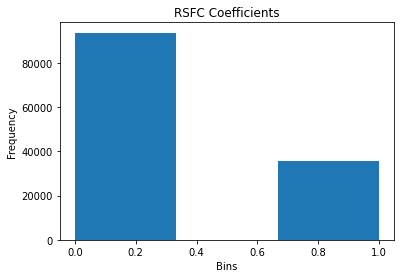

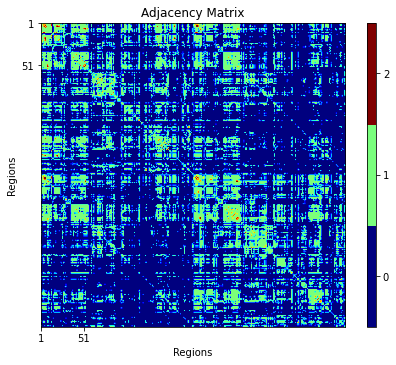

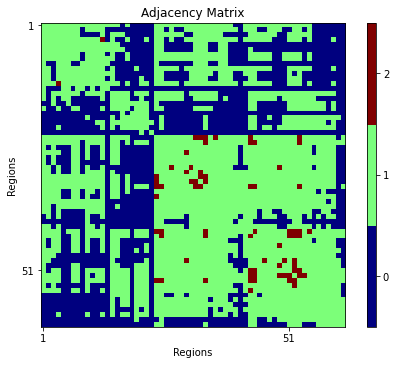

In [ ]:
# Convert FC to adjacency matrix
if pre_load:
  A = np.load(os.path.join(save_dir, 'A.npy'))
  num_ROI = A.shape[0]
else:
  A = RSFC_to_binned_adj(RSFC, 3)

# Reduce number of ROI based on network membership
if not pre_load:
  networks = np.load(os.path.join(parent_dir, 'HCP-data', 'networks.npy'))
  network_dic = np.unique(networks)
  print(f'Networks: {network_dic}')

  max_k = 'none'
  #max_k = 10

  #desired_network_idx = [1, 2, 4, 8] 
  desired_network_idx = [2, 8]
  num_network = len(desired_network_idx)
  print(f'Chosen networks: {network_dic[desired_network_idx]}')
  
  network_ROI = []
  all_ROI = []
  for i in range(num_network):
    temp = np.where(networks == network_dic[desired_network_idx[i]])
    temp = temp[0]

    if isinstance(max_k, int):
      temp = random.choices(temp, k = max_k)

    network_ROI.append(np.array(temp))
    
  all_ROI = np.array(np.concatenate(network_ROI, axis=0))

  print(f'All ROI: {all_ROI}')
  num_ROI = len(all_ROI)

  A = A[all_ROI[:,np.newaxis], all_ROI]
  # Plot figure
  fig, ax = plt.subplots(1, 1, figsize=(6, 6))
  plt.title('Adjacency Matrix')
  plt.xlabel('Regions')
  plt.xticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))
  plt.ylabel('Regions')
  plt.yticks(np.arange(0,num_ROI,50),np.arange(1,num_ROI+1,50))

  cmap = plt.cm.jet
  cmaplist = [cmap(i) for i in range(cmap.N)]

  cmap = mpl.colors.LinearSegmentedColormap.from_list(
      'Custom cmap', cmaplist, cmap.N)

  bounds = np.arange(len(np.unique(A))+1)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


  plt.imshow(A, cmap=cmap, origin='upper')


  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="3%", pad=0.3)
  cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, 
                                  spacing='proportional', ticks=bounds-0.5, boundaries=bounds, format='%1i')

### Set initial and target states

In [ ]:
initial_state_cue = np.load(os.path.join(parent_dir, 'HCP-data', 'initial_state_cue.npy'))
target_state_lh = np.load(os.path.join(parent_dir, 'HCP-data', 'target_state_lh.npy'))
target_state_rh = np.load(os.path.join(parent_dir, 'HCP-data', 'target_state_rh.npy'))
target_state_lf = np.load(os.path.join(parent_dir, 'HCP-data', 'target_state_lf.npy'))
target_state_rf = np.load(os.path.join(parent_dir, 'HCP-data', 'target_state_rf.npy'))
target_state_t = np.load(os.path.join(parent_dir, 'HCP-data', 'target_state_t.npy'))

In [ ]:
def normalize(x, bounds):
  lower = bounds[0]
  upper = bounds[1]
  return (x - np.min(x)) / (np.max(x) - np.min(x)) * (upper - lower) + lower


if pre_load:
  action_lim = np.load(os.path.join(save_dir, 'action_lim.npy'))
  state_lim = np.load(os.path.join(save_dir, 'state_lim.npy'))
  init_state = np.load(os.path.join(save_dir, 'init_state.npy'))
  target_state = np.load(os.path.join(save_dir, 'target_state.npy'))
  rho = np.load(os.path.join(save_dir, 'rho.npy'))
  state_update_scaler = np.load(os.path.join(save_dir, 'state_update_scaler.npy'))
else:
  action_lim = np.array([-1,1])
  state_lim = np.array([0,1])
  init_state = normalize(initial_state_cue, state_lim)
  init_state = init_state[all_ROI]
  target_state = normalize(target_state_lh, state_lim)
  target_state = target_state[all_ROI]
  rho = 0 #0.7
  state_update_scaler = 0.1

### Functions to check if matrix is invertible
For purpose of testing controllability Gramian
[Adapted from code from Coduber](https://coduber.com/how-to-tell-if-a-matrix-is-invertible/)

In [ ]:
def isInvertible(A):
  condA = np.linalg.cond(A)
  print(f'Condition number: {condA}')

  if condA == np.inf:
    print('Singular')
  elif condA > 100:
    print('Almost singular')
  else:
    print('Invertible')

  return condA


### Functions to help define agents according to region controllability
Adapted from [Gu *et al.* (2015)](https://www.nature.com/articles/ncomms9414)

In [ ]:
def GramianFun( W, B ):
# GramianFun computes the H2/Gramian and smallest eigen values for given A,B
# with model x(t + 1) = Ax(t) + Bu(t),
# A is NxN ajaciency matrix, B is Nxk control matrix
# H2 = sqrt(trace(sum_k A^kBB^T(A^T)^k))

  eigs,_ = np.linalg.eig(W)
  A = W / (1 + np.max(eigs))

  [T, U] = schur(A,'real')  # Schur stability
  midMat = U.T @ (B @ B.T) @ U
  v = np.expand_dims(diag(T),1)
  P = midMat /(1 - v @ v.T)

  H2 = np.sqrt(np.trace(P));
  _, eig_values, _ = np.linalg.svd(P);
  smeig = eig_values[-1];

  return H2, smeig

In [ ]:
def numel(A):
  print('numel fun used')
  return A.shape[0] * A.shape[1]

In [ ]:
def boundaryDetection(network, subIndex, thresholdRatio):
# FUNCTION:
#        This function bipartitionate the sub-network into two parts using the
#        Fieldler vector.
# INPUT:
#        network  : the whole network
#        subIndex : the subnetwork index
#        thresholdRatio : the threshold ratio to detect boundary points
# OUTPUT: 
#        ind : the index of the detected boundary points
#        newPart1: the index of the points in group-1
#        newPart2: the index of the points in group-2
  subNetwork = network[subIndex, subIndex];
  threshold = np.max(subNetwork) * thresholdRatio;

  if subNetwork.shape[0] == 1:
    ind = subIndex;
    newPart1 = [];
    newPart2 = [];
    return ind, newPart1, newPart2 

  L = diag(sum(subNetwork)) - subNetwork;
  _,_,V  = svd(L);
  fV = V[:, -2];
  ind1 = np.where(fV >=0);
  ind2 = np.where(fV <0);

  if (isempty(ind1[0]) | isempty(ind2[0])):
      midNum = floor((1+length(fV))/2);
      ind1 = np.arange(midNum);
      ind2 = np.arange(midNum,length(fV));

  newPart = zeros(1, numel(fV));
  for j in range(numel(ind1)):
      lala = sum(subNetwork(ind1[j], ind2));
      if ( lala >= threshold):
          newPart[ind1[j]] = 1

  for j in range(numel(ind2)):
      lala = sum(subNetwork(ind2[j], ind1))
      if ( lala >= threshold):
          newPart[ind2[j]] = 1

  ind = subIndex[newPart == 1]
  newPart1 = subIndex[ind1]
  newPart2 = subIndex[ind2]

  return ind, newPart1, newPart2

In [ ]:
def controlPointsDetectionRobust(A, cardK, threshold, res, init_partition):
# FUNCTION:
#           return the index of the control points 
# INPUT: 
#           A: network/adjacient matrix
#           cardK: number of control points
#           threshold: threshold ratio of detecting the boundary points
#           init_partition: initial partition
  

  #G = nx.from_numpy_matrix(A)
  #partition = community_louvain.best_partition(G, weight='weight', resolution=res, randomize=False)
  #partition = partition.values()
  #partition = np.array([*partition])
  partition = init_partition

  Kset = np.zeros((A.shape[0],));
  I = np.eye(A.shape[0]);

  communities = np.unique(partition);
  A = A / np.max(A);
  for i in communities:
    ind1 = np.where(partition == i); 
    ind1 = ind1[0]
    ind2 = (partition != i);
    for j in range(len(ind1)):
        lala = np.sum(A[ind1[j], ind2]);
        if ( lala >= threshold):
            Kset[ind1[j]] = 1;

  print(f'Init control ROI: {Kset}')
  while (sum(Kset) < cardK):
    uniPVal = np.unique(partition)
    eigVals = np.zeros((len(uniPVal),))
    for i in range(len(uniPVal)):
        if all(Kset[partition == uniPVal[i]]):
          eigVals[i] = np.inf;
        else:
          _, eigVals[i] = GramianFun(A, I[:, (partition == uniPVal[i])]);

    if (all(eigVals == np.inf)):
        ind = np.ones((A.shape[0],));
        return

    l = np.argmin(eigVals)
    indL = np.where(partition == uniPVal[l])
    boundInd, newPart, _ = boundaryDetection(A, indL, threshold)
    Kset[boundInd] = 1;
    if np.any([x > 0 for x in newPart]):
        partition[newPart] = max(uniPVal) + 1;


  return Kset

### Choose agents according to certain criteria and create matrix B

Initial partition: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Init control ROI: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Num control ROI: 23
Num total ROI: 62
Condition number: inf
Singular


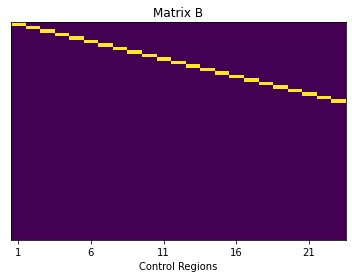

In [ ]:
# Eventually choose better way to pick ctrl ROI
if pre_load:
  B = np.load(os.path.join(save_dir, 'B.npy'))
  ctrl_ROI = np.load(os.path.join(save_dir, 'ctrl_ROI.npy'))
  num_ctrl_ROI = len(ctrl_ROI)
else:
  A_temp = state_update_scaler * A

  #G = nx.from_numpy_matrix(A)
  #init_partition = community_louvain.best_partition(G, weight='weight', resolution=res, randomize=False)
  #init_partition = init_partition.values()
  #init_partition = np.array([*partition])

  init_partition = []
  for i in range(num_network):
    init_partition.append(i * np.ones(len(network_ROI[i]),)) 
  
  init_partition = np.concatenate(init_partition, axis = 0)
  print(f'Initial partition: {init_partition}')

  cardK = 6
  thresh = 20
  res = 1.6

  ctrl_ROI = np.where(controlPointsDetectionRobust(A_temp, cardK, thresh, res, init_partition))
  ctrl_ROI = ctrl_ROI[0]
  num_ctrl_ROI = len(ctrl_ROI)
  print(f'Num control ROI: {num_ctrl_ROI}')
  print(f'Num total ROI: {num_ROI}')
  #num_ctrl_ROI = 150
  #ctrl_ROI = np.sort(np.argpartition(control_vals, -num_ctrl_ROI)[-num_ctrl_ROI:])
  B = np.zeros((num_ROI,num_ctrl_ROI))
  B[ctrl_ROI,:] = diag(np.ones((num_ctrl_ROI,)))

plt.imshow(B, aspect='auto', interpolation='none', origin='upper')

plt.title('Matrix B')
plt.xlabel('Control Regions')
xticks = plt.xticks()
xticks = [int(x) for x in xticks[0][1:-1]]
#plt.xticks(np.arange(0,num_ctrl_ROI),np.array(ctrl_ROI)+1)
plt.xticks(xticks,np.array(ctrl_ROI[xticks])+1)
plt.yticks([])

gramian = A.T @ (B @ B.T) @ A
condG = isInvertible(gramian)

In [ ]:
env = CustomEnv(A, B, init_state, target_state, rho, state_update_scaler, action_lim, state_lim)
#env = PosNegRewardEnv(A, B, init_state, target_state, rho, state_update_scaler, action_lim, state_lim)
from stable_baselines3.common.env_checker import check_env
check_env(env)

In [ ]:
# Sanity check on state vals
action = np.random.uniform(action_lim[0], action_lim[1], (num_ctrl_ROI,))
print('action: {}'.format(action))
state = np.random.uniform(state_lim[0], state_lim[1], (num_ROI,))
print('state: {}'.format(state))
next_state = state_update_scaler * A @ state + B @ action
print('next state: {}'.format(next_state))

action: [-0.16595599  0.44064899 -0.99977125 -0.39533485 -0.70648822 -0.81532281
 -0.62747958 -0.30887855 -0.20646505  0.07763347 -0.16161097  0.370439
 -0.5910955   0.75623487 -0.94522481  0.34093502 -0.1653904   0.11737966
 -0.71922612 -0.60379702  0.60148914  0.93652315 -0.37315164  0.38464523
  0.7527783   0.78921333 -0.82991158 -0.92189043 -0.66033916  0.75628501
 -0.80330633 -0.15778475  0.91577906  0.06633057  0.38375423 -0.36896874
  0.37300186  0.66925134 -0.96342345  0.50028863  0.97772218  0.49633131
 -0.43911202  0.57855866 -0.79354799 -0.10421295  0.81719101 -0.4127717
 -0.42444932 -0.73994286 -0.96126608  0.35767107 -0.57674377 -0.46890668
 -0.01685368 -0.89327491  0.14823521 -0.70654285  0.17861107  0.39951672
 -0.79533114 -0.17188802  0.38880032 -0.17164146 -0.90009308  0.07179281
  0.32758929  0.02977822  0.88918951  0.17311008  0.80680383 -0.72505059
 -0.72144731  0.61478258 -0.20464633 -0.66929161  0.85501716 -0.30446828
  0.50162421  0.45199597  0.76661218  0.247344

In [ ]:
rho * np.linalg.norm(action)

0.0

In [ ]:
1 - np.log(1 + np.sum(np.abs(target_state - state)))/np.log(1 + np.sum(np.abs(target_state - state)))

0.0

### Save current variables

In [ ]:
if not pre_load:
  np.save(os.path.join(save_dir,'A'), A)
  np.save(os.path.join(save_dir,'B'), B)
  np.save(os.path.join(save_dir,'ctrl_ROI'), ctrl_ROI)
  np.save(os.path.join(save_dir,'init_state'), init_state)
  np.save(os.path.join(save_dir,'target_state'), init_state)
  np.save(os.path.join(save_dir,'rho'), rho)
  np.save(os.path.join(save_dir,'state_update_scaler'), state_update_scaler)
  np.save(os.path.join(save_dir,'action_lim'), action_lim)
  np.save(os.path.join(save_dir,'state_lim'), action_lim)
  np.save(os.path.join(save_dir,'all_ROI'), all_ROI)

#**Neural network implementation**

## Algorithm code

### Create Critic and Actor classes



In [ ]:
EPS = 0.003

def fanin_init(size, fanin=None):
	fanin = fanin or size[0]
	v = 1. / np.sqrt(fanin)
	return torch.Tensor(size).uniform_(-v, v)

class Critic(nn.Module):

  def __init__(self, state_dim, action_dim):
    """
    :param state_dim: Dimension of input state (int)
    :param action_dim: Dimension of input action (int)
    :return:
    """
    super(Critic, self).__init__()

    self.state_dim = state_dim
    self.action_dim = action_dim

    self.fcs1 = nn.Linear(state_dim,256)
    self.fcs1.weight.data = fanin_init(self.fcs1.weight.data.size())
    self.fcs2 = nn.Linear(256,128)
    self.fcs2.weight.data = fanin_init(self.fcs2.weight.data.size())

    self.fca1 = nn.Linear(action_dim,128)
    self.fca1.weight.data = fanin_init(self.fca1.weight.data.size())

    self.fc2 = nn.Linear(256,128)
    self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())

    self.fc3 = nn.Linear(128,1)
    self.fc3.weight.data.uniform_(-EPS,EPS)

  def forward(self, state, action):
    """
    returns Value function Q(s,a) obtained from critic network
    :param state: Input state (Torch Variable : [n,state_dim] )
    :param action: Input Action (Torch Variable : [n,action_dim] )
    :return: Value function : Q(S,a) (Torch Variable : [n,1] )
    """
    s1 = F.relu(self.fcs1(state))
    #s1 = F.leaky_relu(self.fcs1(state))
    s2 = F.relu(self.fcs2(s1))
    #s2 = F.relu(self.fcs2(s1))
    a1 = F.relu(self.fca1(action))
    #a1 = F.leaky_relu(self.fca1(action))
    x = torch.cat((s2,a1),dim=1)

    x = F.relu(self.fc2(x))
    #x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)

    return x


class Actor(nn.Module):

  def __init__(self, state_dim, action_dim, action_lim):
    """
    :param state_dim: Dimension of input state (int)
    :param action_dim: Dimension of output action (int)
    :param action_lim: Used to limit action in [-action_lim,action_lim]
    :return:
    """
    super(Actor, self).__init__()

    self.state_dim = state_dim
    self.action_dim = action_dim
    self.action_lim = action_lim

    self.fc1 = nn.Linear(state_dim,256)
    self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())

    self.fc2 = nn.Linear(256,128)
    self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())

    self.fc3 = nn.Linear(128,64)
    self.fc3.weight.data = fanin_init(self.fc3.weight.data.size())

    self.fc4 = nn.Linear(64,action_dim)
    self.fc4.weight.data.uniform_(-EPS,EPS)

  def forward(self, state):
    """
    returns policy function Pi(s) obtained from actor network
    this function is a gaussian prob distribution for all actions
    with mean lying in (-1,1) and sigma lying in (0,1)
    The sampled action can , then later be rescaled
    :param state: Input state (Torch Variable : [n,state_dim] )
    :return: Output action (Torch Variable: [n,action_dim] )
    """
    x = F.relu(self.fc1(state))
    #x = F.leaky_relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    #x = F.leaky_relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    #x = F.leaky_relu(self.fc3(x))
    action = torch.tanh(self.fc4(x))

    action = action * self.action_lim

    return action

### Create Trainer class

In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
GAMMA = 0.5 # 0.99
TAU = 0.001


class Trainer:

  def __init__(self, state_dim, action_dim, action_lim, ram):
    """
    :param state_dim: Dimensions of state (int)
    :param action_dim: Dimension of action (int)
    :param action_lim: Used to limit action in [-action_lim,action_lim]
    :param ram: replay memory buffer object
    :return:
    """
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.action_lim = action_lim
    self.ram = ram
    self.iter = 0
    self.noise = OrnsteinUhlenbeckActionNoise(self.action_dim)

    self.actor = Actor(self.state_dim, self.action_dim, self.action_lim).to(DEVICE)
    self.target_actor = Actor(self.state_dim, self.action_dim, self.action_lim).to(DEVICE)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),LEARNING_RATE)

    self.critic = Critic(self.state_dim, self.action_dim).to(DEVICE)
    self.target_critic = Critic(self.state_dim, self.action_dim).to(DEVICE)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),LEARNING_RATE)

    hard_update(self.target_actor, self.actor)
    hard_update(self.target_critic, self.critic)

  def get_exploitation_action(self, state):
    """
    gets the action from target actor added with exploration noise
    :param state: state (Numpy array)
    :return: sampled action (Numpy array)
    """
    #state = Variable(torch.from_numpy(state))
    state = torch.from_numpy(state).to(DEVICE)
    action = self.target_actor.forward(state).detach()
    return action.data.cpu().numpy()

  def get_exploration_action(self, state):
    """
    gets the action from actor added with exploration noise
    :param state: state (Numpy array)
    :return: sampled action (Numpy array)
    """
    #state = Variable(torch.from_numpy(state))
    state = torch.from_numpy(state).to(DEVICE)
    action = self.actor.forward(state).detach()
    new_action = action.data.cpu().numpy() + (self.noise.sample() * self.action_lim)
    return new_action

  def optimize(self):
    """
    Samples a random batch from replay memory and performs optimization
    :return:
    """
    batch = self.ram.sample(BATCH_SIZE)

    #s1 = Variable(torch.from_numpy(s1))
    #a1 = Variable(torch.from_numpy(a1))
    #r1 = Variable(torch.from_numpy(r1))
    #s2 = Variable(torch.from_numpy(s2))

    s1, a1, r1, s2 = [torch.from_numpy(item).to(DEVICE) for item in batch]

    # s1 = torch.from_numpy(s1)
    # a1 = torch.from_numpy(a1)
    # r1 = torch.from_numpy(r1)
    # s2 = torch.from_numpy(s2)    

    # ---------------------- optimize critic ----------------------
    # Use target actor exploitation policy here for loss evaluation
    a2 = self.target_actor.forward(s2).detach()
    next_val = torch.squeeze(self.target_critic.forward(s2, a2).detach())
    # y_exp = r + gamma*Q'( s2, pi'(s2))
    y_expected = r1 + GAMMA*next_val
    # y_pred = Q( s1, a1)
    y_predicted = torch.squeeze(self.critic.forward(s1, a1))
    # compute critic loss, and update the critic
    loss_critic = F.smooth_l1_loss(y_predicted, y_expected)
    self.critic_optimizer.zero_grad()
    loss_critic.backward()
    self.critic_optimizer.step()

    # ---------------------- optimize actor ----------------------
    pred_a1 = self.actor.forward(s1)
    loss_actor = -1*torch.sum(self.critic.forward(s1, pred_a1))
    self.actor_optimizer.zero_grad()
    loss_actor.backward()
    self.actor_optimizer.step()

    soft_update(self.target_actor, self.actor, TAU)
    soft_update(self.target_critic, self.critic, TAU)

  def save_models(self, episode_count):
    """
    saves the target actor and critic models
    :param episode_count: the count of episodes iterated
    :return:
    """
    torch.save(self.target_actor.state_dict(), os.path.join(save_dir_specific, str(episode_count) + '_actor.pt'))
    torch.save(self.target_critic.state_dict(), os.path.join(save_dir_specific, str(episode_count) + '_critic.pt'))
    print('Models saved successfully')

  def load_models(self, episode):
    """
    loads the target actor and critic models, and copies them onto actor and critic models
    :param episode: the count of episodes iterated (used to find the file name)
    :return:
    """
    self.actor.load_state_dict(torch.load(os.path.join(save_dir_specific, str(episode_count) + '_actor.pt')))
    self.critic.load_state_dict(torch.load(os.path.join(save_dir_specific, str(episode_count) + '_critic.pt')))
    hard_update(self.target_actor, self.actor)
    hard_update(self.target_critic, self.critic)
    print('Models loaded succesfully')

### Define util functions

In [ ]:
def soft_update(target, source, tau):
	"""
	Copies the parameters from source network (x) to target network (y) using the below update
	y = TAU*x + (1 - TAU)*y
	:param target: Target network (PyTorch)
	:param source: Source network (PyTorch)
	:return:
	"""
	for target_param, param in zip(target.parameters(), source.parameters()):
		target_param.data.copy_(
			target_param.data * (1.0 - tau) + param.data * tau
		)


def hard_update(target, source):
	"""
	Copies the parameters from source network to target network
	:param target: Target network (PyTorch)
	:param source: Source network (PyTorch)
	:return:
	"""
	for target_param, param in zip(target.parameters(), source.parameters()):
			target_param.data.copy_(param.data)


def save_training_checkpoint(state, is_best, episode_count):
	"""
	Saves the models, with all training parameters intact
	:param state:
	:param is_best:
	:param filename:
	:return:
	"""
	filename = str(episode_count) + 'checkpoint.path.rar'
	torch.save(state, filename)
	if is_best:
		shutil.copyfile(filename, 'model_best.pth.tar')


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:

	def __init__(self, action_dim, mu = 0, theta = 0.15, sigma = 0.2):
		self.action_dim = action_dim
		self.mu = mu
		self.theta = theta
		self.sigma = sigma
		self.X = np.ones(self.action_dim) * self.mu

	def reset(self):
		self.X = np.ones(self.action_dim) * self.mu

	def sample(self):
		dx = self.theta * (self.mu - self.X)
		dx = dx + self.sigma * np.random.randn(len(self.X))
		self.X = self.X + dx
		return self.X

### Create MemoryBuffer class

In [ ]:
class MemoryBuffer:

  def __init__(self, size):
    self.buffer = []
    self.max_size = size
    self.len = 0

  def sample(self, count):
    """
    samples a random batch from the replay memory buffer
    :param count: batch size
    :return: batch (numpy array)
    """
    batch = []
    count = min(count, self.len)
    batch = random.sample(self.buffer, count)

    s_arr = np.float32([arr[0] for arr in batch])
    a_arr = np.float32([arr[1] for arr in batch])
    r_arr = np.float32([arr[2] for arr in batch])
    s1_arr = np.float32([arr[3] for arr in batch])

    return s_arr, a_arr, r_arr, s1_arr

  def len(self):
    return self.len

  def add(self, s, a, r, s1):
    """
    adds a particular transaction in the memory buffer
    :param s: current state
    :param a: action taken
    :param r: reward received
    :param s1: next state
    :return:
    """
    transition = (s,a,r,s1)
    self.len += 1
    if self.len > self.max_size:
      self.len = self.max_size
    self.buffer.append(transition)

# Experiments

## Training


### HPs and tracking stuff

In [ ]:
MAX_EPISODES = 1000
MAX_STEPS = 1000
MAX_BUFFER = 1000000
MAX_TOTAL_REWARD = 300

np.save(os.path.join(save_dir_specific,'GAMMA'), GAMMA)
np.save(os.path.join(save_dir_specific,'LEARNING_RATE'), LEARNING_RATE)
np.save(os.path.join(save_dir_specific,'TAU'), TAU)
np.save(os.path.join(save_dir_specific,'BATCH_SIZE'), BATCH_SIZE)
np.save(os.path.join(save_dir_specific,'EPS'), EPS)
np.save(os.path.join(save_dir_specific,'MAX_EPISODES'), MAX_EPISODES)
np.save(os.path.join(save_dir_specific,'MAX_STEPS'), MAX_STEPS)
np.save(os.path.join(save_dir_specific,'MAX_BUFFER'), MAX_BUFFER)
np.save(os.path.join(save_dir_specific,'MAX_TOTAL_REWARD'), MAX_TOTAL_REWARD)

S_DIM = env.observation_space.shape[0]
A_DIM = env.action_space.shape[0]
A_MAX = action_lim[1]

ram = MemoryBuffer(MAX_BUFFER)
trainer = Trainer(S_DIM, A_DIM, A_MAX, ram)

print(' State Dimensions :- ', S_DIM)
print(' Action Dimensions :- ', A_DIM)
print(' Action Max :- ', A_MAX)
print('Initial distance :-', np.linalg.norm(init_state - target_state))


episode_scores = np.zeros((MAX_EPISODES,))
episode_rewards = []
episode_distances = np.zeros((MAX_EPISODES,))
episode_actions = np.zeros((MAX_EPISODES,num_ctrl_ROI))
episode_states = np.zeros((MAX_EPISODES, S_DIM))
episode_all_states = []
episode_all_actions = []
episode_end_distances = []

 State Dimensions :-  360
 Action Dimensions :-  155
 Action Max :-  1
Initial distance :- 0.0


### Let the learning begin

In [ ]:
for _ep in tqdm(range(MAX_EPISODES)):
  new_observation = env.reset()
  episode_score = []
  episode_action = []
  episode_state = []

  for r in range(MAX_STEPS):

    state = np.float32(new_observation)

    action = trainer.get_exploration_action(state)

    new_observation, reward, done, info = env.step(action)

    episode_score.append(reward)
    episode_action.append(action)
    episode_state.append(state)

    if done:
      # next_state = None
      next_state = np.float32(new_observation)
    else:
      next_state = np.float32(new_observation)
      ram.add(state, action, reward, next_state)


    # perform optimization
    trainer.optimize()
    if done:
      break

  # append last state to state dict
  episode_state.append(next_state)

  # check memory consumption and clear memory
  gc.collect()

  if _ep%100 == 0:
    trainer.save_models(_ep)


  episode_all_states.append(episode_state)
  episode_all_actions.append(episode_action)
  curr_dist = np.linalg.norm(next_state - target_state)
  episode_end_distances.append(curr_dist)

  episode_scores[_ep] = np.mean(episode_score)
  episode_rewards.append(episode_score)
  episode_states[_ep] = next_state
  episode_distances[_ep] = np.linalg.norm(target_state - next_state)
  episode_actions[_ep] = np.mean(episode_action, 0)

  if _ep >= 100 : 
    mean_over_episodes = np.mean(episode_scores[_ep-100:_ep])
  else: 
    mean_over_episodes = np.mean(episode_scores[:_ep])

  #print(f"Episode: {_ep}, done: {done}, state: {next_state[0:10]}, avg reward: {episode_scores[_ep]}, avg episode reward: {mean_over_episodes}")
  print(f"Episode: {_ep}, done: {done}, curr_dist: {curr_dist}, return: {np.sum(episode_score)}, avg episode reward: {mean_over_episodes}")


print('Completed episodes')

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Models saved successfully
Episode: 0, done: False, curr_dist: 9.143728109723174, return: -97598.77542834284, avg episode reward: nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 1, done: False, curr_dist: 8.785454128423632, return: -88651.18252437958, avg episode reward: -97.59877542834283
Episode: 2, done: False, curr_dist: 8.678947116934802, return: -86953.83464562288, avg episode reward: -93.1249789763612
Episode: 3, done: False, curr_dist: 8.599128386891882, return: -86956.51592727707, avg episode reward: -91.06793086611509
Episode: 4, done: False, curr_dist: 8.51393958660627, return: -86553.94001196674, avg episode reward: -90.04007713140558
Episode: 5, done: False, curr_dist: 8.618538162666065, return: -86275.53676952506, avg episode reward: -89.34284970751781
Episode: 6, done: False, curr_dist: 8.492393068273271, return: -86959.82527315608, avg episode reward: -88.83163088451903
Episode: 7, done: False, curr_dist: 8.65297817833774, return: -87166.91956634948, avg episode reward: -88.56423008289575
Episode: 8, done: False, curr_dist: 8.573551440350116, return: -86888.7295596018, avg episode reward: -88.38956626832746
Episode: 9, done: False, cur

## Analysis

### Plotting functions


In [ ]:
def plot_ep_data(ep_data: 'List',  title: str, xlabel: str, ylabel: str, color: str, axis: int = 0):
  """ ep_data is a list of dimension (num_episodes, [num_steps, d] where d is e.g. observation space size or 1""" 
  avg_data = np.mean(ep_data, axis=axis)
  var_data = np.var(ep_data, axis=axis)

  length = avg_data.shape[0]
  plot_idx = [int(x) for x in np.linspace(0,length, length).tolist()]
  plot_idx = np.array(plot_idx)
  xticks = np.arange(0,len(plot_idx),20)
  tick_idx = [int(x) for x in xticks]

  figure(figsize=(12, 6))
  plt.plot(avg_data, color=color)
  plt.fill_between(plot_idx, avg_data-var_data, avg_data + var_data, alpha=0.3, color=color)
  plt.xticks(xticks, plot_idx[tick_idx])
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

def smoothen(ep_data: 'List', past_episodes: int=100, smoothen_f=np.mean): 
  return [smoothen_f(ep_data[i-past_episodes:i] for i in range(len(ep_data)))]

### Plot figures

In [ ]:
ave_episode_scores = np.zeros((episode_scores.shape))
ave_episode_distances = np.zeros((episode_distances.shape))
ave_episode_actions = np.zeros((episode_actions.shape))
ave_episode_actions2 = np.mean(episode_all_actions,axis=0)

for _ep in range(MAX_EPISODES):
  if _ep >= 100:
    ave_episode_scores[_ep] = np.mean(episode_scores[_ep-100:_ep])
    ave_episode_distances[_ep] = np.mean(episode_distances[_ep-100:_ep])
    ave_episode_actions[_ep] = np.mean(episode_actions[_ep-100:_ep])
  elif _ep == 0:
    ave_episode_scores[_ep] = np.mean(episode_scores[_ep])
    ave_episode_distances[_ep] = np.mean(episode_distances[_ep])
    ave_episode_actions[_ep] = np.mean(episode_actions[_ep])
  else:
    ave_episode_scores[_ep] = np.mean(episode_scores[:_ep])
    ave_episode_distances[_ep] = np.mean(episode_distances[_ep])
    ave_episode_actions[_ep] = np.mean(episode_actions[_ep])
  

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,6))

ax1.plot(episode_scores)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Score')
ax1.set_title('Episode Score')

ax2.plot(ave_episode_scores)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Score')
ax2.set_title('Average of Episode Score, Past 100')

fname = os.path.join(save_dir_specific, 'Episode Score')
plt.savefig(fname, dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,6))

ax1.plot(episode_distances)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Distance to Target')
ax1.set_title('Distance to Target State')

ax2.plot(ave_episode_distances)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Distance to Target')
ax2.set_title('Average of Distance to Target State, Past 100')

#plt.show()

fname = os.path.join(save_dir_specific, 'Distance to Target State')
plt.savefig(fname, dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,6))

ax1.plot(episode_actions)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Mean Action')
ax1.set_title('Mean Episode Action')

ax2.plot(ave_episode_actions)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Mean Action')
ax2.set_title('Average of Mean Episode Action, Past 100')

#plt.show()

fname = os.path.join(save_dir_specific, 'Episode Action')
plt.savefig(fname, dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

f, ax = plt.subplots(1, 1, figsize=(9,6))

ax.plot(ave_episode_actions2)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean Action')
ax.set_title('Average of Episode Action Across Steps')

#plt.show()

fname = os.path.join(save_dir_specific, 'Episode Action Across Steps')
plt.savefig(fname, dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [ ]:
ep_data = episode_rewards
# ep_data = np.array(episode_rewards).T

ep_data = episode_rewards
plot_ep_data(ep_data, title='Revard avg over episodes', xlabel='Episodes', ylabel='Reward', color='b')

fname = os.path.join(save_dir, 'Actor Critic', datestr, 'Revard avg over episodes')
savefig(fname, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [ ]:
# ep_data = episode_rewards
ep_data = np.array(episode_rewards).T
plot_ep_data(ep_data, title='Reward avg over steps', xlabel='Episodes', ylabel='Reward', color='g')

fname = os.path.join(save_dir, 'Actor Critic', datestr, 'Reward avg over steps'))
savefig(fname, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [ ]:
# ep_data = episode_rewards
# ep_data = np.array(episode_rewards).T
ep_data = [[np.linalg.norm(state) for state in states] for states in episode_all_states]
plot_ep_data(ep_data, title='State norm per step', xlabel='Steps', ylabel='State norm', color='r')

fname = os.path.join(save_dir, 'Actor Critic', datestr, 'State norm per step'))
savefig(fname, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [ ]:
ep_data = [[np.linalg.norm(action) for action in actions] for actions in episode_all_actions]
plot_ep_data(ep_data, title='Action norm per step', xlabel='Steps', ylabel='Action norm', color='r')

In [ ]:
ep_data = [[min(action) for action in actions] for actions in episode_all_actions]
plot_ep_data(ep_data, title='Action min per step', xlabel='Steps', ylabel='Action min', color='r')

In [ ]:
ep_data = [[max(action) for action in actions] for actions in episode_all_actions]
plot_ep_data(ep_data, title='Action max per step', xlabel='Steps', ylabel='Action max', color='r')